In [1]:
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.optim as optim #for gradient descent
import torchvision.models

import time
import os
import numpy as np

import matplotlib.pyplot as plt


In [2]:
use_cuda = True

if use_cuda and torch.cuda.is_available():
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [3]:
# Data Loading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import shutil

# Delete the directory and its contents
# shutil.rmtree('/root/datasets/images_short')
# shutil.rmtree('/root/datasets/__MACOSX/images_short')
# shutil.rmtree('/root/datasets/__MACOSX')

In [4]:
!unzip '/content/drive/My Drive/fer2013_augmented.zip' -d '/root/datasets'

Streaming output truncated to the last 5000 lines.
  inflating: /root/datasets/fer2013_augmented/validation/neutral/5119.jpg  
  inflating: /root/datasets/__MACOSX/fer2013_augmented/validation/neutral/._5119.jpg  
  inflating: /root/datasets/fer2013_augmented/validation/neutral/21852.jpg  
  inflating: /root/datasets/__MACOSX/fer2013_augmented/validation/neutral/._21852.jpg  
  inflating: /root/datasets/fer2013_augmented/validation/neutral/10457.jpg  
  inflating: /root/datasets/__MACOSX/fer2013_augmented/validation/neutral/._10457.jpg  
  inflating: /root/datasets/fer2013_augmented/validation/neutral/2104.jpg  
  inflating: /root/datasets/__MACOSX/fer2013_augmented/validation/neutral/._2104.jpg  
  inflating: /root/datasets/fer2013_augmented/validation/neutral/2605.jpg  
  inflating: /root/datasets/__MACOSX/fer2013_augmented/validation/neutral/._2605.jpg  
  inflating: /root/datasets/fer2013_augmented/validation/neutral/22482.jpg  
  inflating: /root/datasets/__MACOSX/fer2013_augmente

In [6]:
# define training and test data directories
data_dir = '/root/datasets/fer2013_augmented'
train_dir = os.path.join(data_dir, 'train/')
val_dir = os.path.join(data_dir, 'validation/')
print(train_dir)
print(val_dir)

# classes are folders in each directory with these names
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

/root/datasets/fer2013_augmented/train/
/root/datasets/fer2013_augmented/validation/


In [10]:
# load and transform data using ImageFolder

# resize all images to 224 x 224
data_transform = transforms.Compose([transforms.Resize((224, 224)),
                                     transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                     transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
val_data = datasets.ImageFolder(val_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num validation images: ', len(val_data))
print(train_data.class_to_idx)
print(val_data.class_to_idx)

Num training images:  30549
Num validation images:  7642
{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [11]:
# define dataloader parameters
batch_size  = 1024
num_workers = 0

# prepare data loaders
def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

relevant_train_indices = get_relevant_indices(train_data, ['angry','disgust','fear','happy','neutral','sad','surprise'], ['angry','disgust','fear','happy','neutral','sad','surprise'])
relevant_val_indices = get_relevant_indices(val_data, ['angry','disgust','fear','happy','neutral','sad','surprise'], ['angry','disgust','fear','happy','neutral','sad','surprise'])

np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
np.random.shuffle(relevant_train_indices)
np.random.shuffle(relevant_val_indices)

split_train = int(len(relevant_train_indices) * 1)
split_val = int(len(relevant_val_indices) * 1)

relevant_train_indices = relevant_train_indices[:split_train]
relevant_val_indices = relevant_val_indices[:split_val]

train_sampler = SubsetRandomSampler(relevant_train_indices)
val_sampler = SubsetRandomSampler(relevant_val_indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                          num_workers=num_workers, sampler=val_sampler)

In [9]:
print(len(train_loader.sampler))
print(len(val_loader.sampler))

print(len(train_loader))
print(len(val_loader))

30549
7642
30
8


tensor([2, 3, 5,  ..., 5, 5, 4])


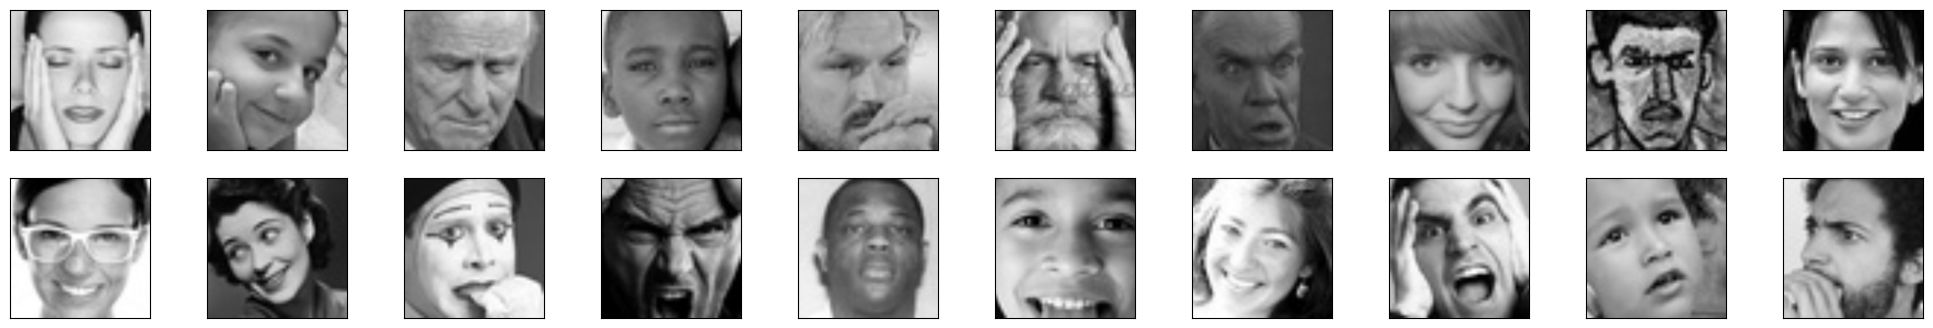

In [ ]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(labels)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi

Sun Jun 30 22:37:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              45W / 400W |      5MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [19]:
# Implement AlexNet

torch.manual_seed(1) # set the random seed

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
print('images shape')
print(images.shape)

# confirm output from AlexNet feature extraction
alexNet = torchvision.models.alexnet(pretrained=True)
features = alexNet.features(images)
print('features shape')
features.shape

images shape
torch.Size([1024, 3, 224, 224])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features shape


torch.Size([1024, 256, 6, 6])

In [37]:
'''
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 10)
        self.fc2 = nn.Linear(10, 7)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
'''
class ClassifierWithDropout(nn.Module):
    def __init__(self):
        super(ClassifierWithDropout, self).__init__()
        self.layer1 = nn.Linear(256 * 6 * 6, 50)
        self.layer2 = nn.Linear(50, 20)
        self.layer3 = nn.Linear(20, 7)
        self.dropout1 = nn.Dropout(0.4)
        self.dropout2 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.4)

    def forward(self, img):
        flattened = img.view(-1, 256 * 6 * 6)  # Adjust for the new input shape
        activation1 = F.relu(self.layer1(self.dropout1(flattened)))
        activation2 = F.relu(self.layer2(self.dropout2(activation1)))
        output = self.layer3(self.dropout3(activation2))
        return output

In [44]:
def train(model, train_loader, val_loader, batch_size=1024, num_iters=100, learn_rate=0.01, weight_decay=0.001):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9, weight_decay=weight_decay)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    while True:
        if n >= num_iters:
            break
        for imgs, labels in iter(train_loader):
            model.train() #*****************************#
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            out = model(ALNC(imgs))             # forward pass
            #print(out.shape)
            #print(labels.shape)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            if n % 10 == 9:
                iters.append(n)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
                val_acc.append(get_accuracy(model, val_loader))   # compute validation accuracy
            n += 1

    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print(train_acc)
    print(val_acc)


def get_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in loader:
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        output = model(ALNC(imgs))
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total


CUDA is available!  Training on GPU ...


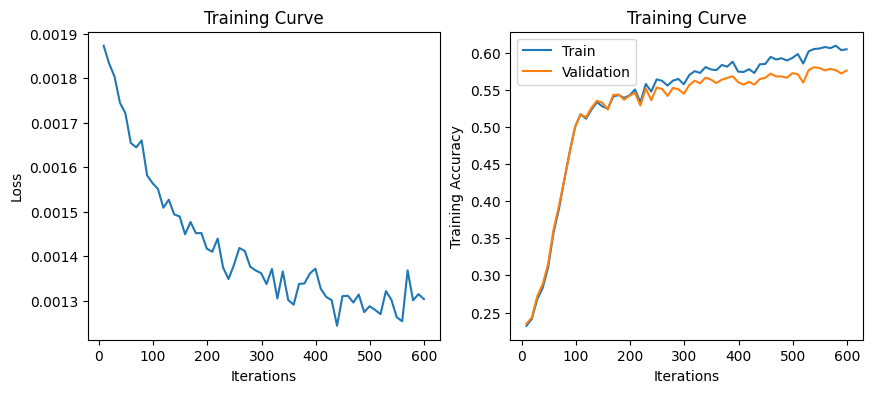

Final Training Accuracy: 0.6043405676126878
Final Validation Accuracy: 0.575765506411934
[0.23221709384922584, 0.24125175946839503, 0.26796294477724314, 0.28311892369635666, 0.3104847949196373, 0.3576549150545026, 0.3894071819044813, 0.42934302268486696, 0.4672820714262333, 0.500703787358015, 0.5169399980359423, 0.5110150905103277, 0.5232577171102164, 0.5331762087138695, 0.5274149726668631, 0.5246652918262463, 0.5407378310255655, 0.5427673573603063, 0.5389701790565976, 0.5422108743330387, 0.5502635110805592, 0.5327506628694884, 0.5576941962093686, 0.5474810959442208, 0.5638155095093129, 0.5618841860617368, 0.5554682641002979, 0.5621460604275099, 0.5644047268323023, 0.5572686503649874, 0.5696422141477626, 0.574879701463223, 0.5725228321712659, 0.5804117974401781, 0.5772038364594586, 0.5762545418835314, 0.5832596811679597, 0.5810010147631673, 0.5876460767946577, 0.5743559527316769, 0.5737012668172444, 0.5775311794166749, 0.5725228321712659, 0.5841435071524436, 0.5845363187011031, 0.59412

In [47]:
use_cuda = True

model = ClassifierWithDropout()
ALNC = alexNet.features

if use_cuda and torch.cuda.is_available():
  ALNC.cuda()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

#proper model
train(model, train_loader, val_loader, num_iters=600)